- EfficientnetB1
- image size: 1536
- 4 transforms
- val transform in predict
- version 4

1) change tiling method from dynamic back to normal 256X256X36.

2) change df in debug mode to val\_df, to found the correlationship between CV and LB

version 24: in LB 0.86 version, tile strategy change from dynamic to 256X256X36 + val\_df (LB 0.872) <br>
version 25: in LB 0.86 version, tile strategy to 256X256X36 + 384X2X2 + val\_df (LB 0.82) <br>
version 26: in LB 0.872 version, 384X4X4 + 256X256X36 + crop + val\_df <br>
version 27: in LB 0.872 version, dynamic + 256X256X36 + crop + val\_df (LB 0.069)<br>
version 28: in version 27, GPU run (LB 0.864) <br>
version 29: in version 24, change to newly trained checkpoints 0.8627 <br>
version 30: in version 24, change to newly trained checkpoints 0.8662 <br>
version 31: in version 30, close internet
version 32: in version 31, change to newly trained checkpoints 0.8716 (LB 0.016) <br>
version 33: fixed the error in version 32 (typo in get\_level functions)(LB 0.0~) <br>
version 34: submit by GPU. 

In [1]:
DEBUG = True

In [2]:
import numpy as np
import pandas as pd
import os, random, glob, cv2, gc
from PIL import Image, ImageChops
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from termcolor import colored

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from functools import partial
import scipy as sp
from PIL import Image
import skimage.io
import sys
import albumentations as A
import openslide
from skimage.filters import threshold_otsu

In [3]:
torch.cuda.empty_cache()
gc.collect()

35

In [4]:
GRAY_TR = 235
N_TR = 0.85
WHITE_TR = 0.95
V = 1

In [5]:
class config:
    IMG_SIZE = 1536
    BS = 1
    SZ = 256    # not used, just to declare start point, 
    N = 36      # not used, just to declare start point, 
    LEVEL = 1   # not used, just to declare start point,

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
# get image_folder and df

COMP_DIR = '../input/prostate-cancer-grade-assessment/'
is_test = os.path.exists(COMP_DIR + 'test_images/')

image_folder = COMP_DIR + 'test_images/' if is_test else COMP_DIR + 'train_images/'
df = pd.read_csv(COMP_DIR + 'test.csv' if is_test else '../input/pandadf/train.csv')

if not is_test:
    df = df[df.split==0]
    if DEBUG:
        df = df.iloc[:30]
    else:
        df = df.iloc[:1000]
        
print(is_test, image_folder, len(df))
display(df.head())

False ../input/prostate-cancer-grade-assessment/train_images/ 30


,image_id,data_provider,isup_grade,gleason_score,split,folder,N,dark>0.8
3,dbf5972f6e8559cf175c232310070b6e,karolinska,1,3+3,0,2,36,0
9,3a08f79c589a9e1d00a258e86a1331ce,radboud,4,4+4,0,1,36,0
16,a4514f8a6800bf122ae746c4f573ee6f,radboud,5,5+5,0,1,100,0
24,11685dcddfbc26b1c8dded45957469dd,karolinska,0,0+0,0,1,36,0
30,1c3c1fe065c9325cbfcab6722d6b9b39,karolinska,0,0+0,0,3,49,0


# Dataset

In [8]:
def get_level(path):
    img = skimage.io.MultiImage(path)[1]
    h, w, _ = img.shape
    
    if h < 1000 and w < 1000:
        img = skimage.io.MultiImage(path)[0]
        
    return img

In [9]:
def filter_otsu(img):
    # HSV - S
    tmp = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    tmp = np.squeeze(tmp[:,:,1])
    otsu_tr = threshold_otsu(tmp)
    otsu_mask = (tmp > otsu_tr) # > 35
      
    otsu_mask = np.stack([otsu_mask, otsu_mask, otsu_mask], axis=-1)
    img = img*otsu_mask
    img[img==0] = 255
    return img

In [10]:
def transpose(img):
    h, w, _ = img.shape
    if w > h:
        img = A.Transpose(p=1)(image=img)['image']
    return img

In [11]:
def get_tiles(img, SZ=256, N=36):
    '''
    dynamically select SZ and N
    img: numpy array since this image has been processed by select_level, remove_gray, crop, and transpose
    Return 
        tiles, SZ, N
    '''
    
    # pad img
    h, w, c = img.shape
    pad_h = (SZ - h % SZ) % SZ 
    pad_w = (SZ - w % SZ) % SZ 

    img2 = np.pad(img, [[pad_h // 2, pad_h - pad_h // 2], 
                        [pad_w // 2, pad_w - pad_w//2], 
                        [0,0]], constant_values=255)
    
    # choose tiles
    img3 = img2.reshape(
        img2.shape[0] // SZ,
        SZ,
        img2.shape[1] // SZ,
        SZ,
        3
    )
    
    new_row, new_col = img3.shape[0], img3.shape[2]
    img3 = img3.transpose(0, 2, 1, 3, 4).reshape(-1, SZ, SZ, 3) # (783, 256, 256, 3)
    info = (img3.reshape(img3.shape[0],-1).sum(-1) < WHITE_TR * SZ*SZ*3*255).sum() # how many tiles are not white
    
    # get new N
    possible_N = int(np.sqrt(info))**2
    if N < possible_N:
        N = possible_N
        
    idxs = np.argsort(img3.reshape(img3.shape[0],-1).sum(-1))[:N]
    tiles = img3[idxs]
    
        
    return tiles, SZ, N, info

In [12]:
def find_tiles(img, SZ=256, N=36):
    tiles, SZ, N, info = get_tiles(img, SZ=SZ, N=N)

    
    # too much white tiles, scale down
    # smallest SZ is 128
    while info <= int(0.85 * N) and SZ > 128:
        SZ = SZ // 2
        tiles, SZ, N, info = get_tiles(img, SZ=SZ, N=N)
        
        
    # too many tiles, scale up
    while N >= 64 and SZ < 384:
        SZ += 128
        N = int(1536/SZ)**2
        tiles, SZ, N, info = get_tiles(img, SZ=SZ, N=N)
        
        
    # pad 
    # for example 32 < 30(0.85*36) 
    if tiles.shape[0] < N:
        tiles = np.pad(tiles, [ [0, N-len(tiles)], [0,0],[0,0],[0,0]], constant_values=255)
        
        
    return tiles, SZ, N, info

In [13]:
class MyTestDataset(Dataset):
    def __init__(self, df, shuffle_df=False):

        # just to test dynamic tiling effect
        # False in eval mode
        if shuffle_df:
            df = shuffle(df)
        self.df = df.reset_index(drop=True)


    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        img_id = self.df.loc[index, 'image_id']
        path = os.path.join(image_folder, f'{img_id}.tiff')
        img = get_level(path)    # select level
        img = filter_otsu(img)   # remove background
        img = transpose(img)            # transpose
        tiles, new_SZ, new_N, info = find_tiles(img, config.SZ, config.N)

        n = int(np.sqrt(new_N))
        images = np.zeros((new_SZ * n, new_SZ * n, 3))
        for h in range(n):
            for w in range(n):
                i = h * n + w
                h1 = h * new_SZ
                w1 = w * new_SZ
                images[h1:h1+new_SZ, w1:w1+new_SZ] = tiles[i]

        images = 255 - images
        images = images.astype(np.float32)
        
        # resize and normalize
        images = cv2.resize(images, (1536, 1536))
        images = A.Normalize(mean=0.5, std=0.5)(image=images)['image']
        
        # 4 transforms 
        a = A.Compose([A.VerticalFlip(p=1)])(image=images)['image']
        b = A.Compose([A.Transpose(p=1)])(image=images)['image']
        c = A.Compose([A.VerticalFlip(p=1),
                       A.Transpose(p=1)])(image=images)['image']
        
        images = np.stack([images, a, b, c]) # (4, 1536, 1536, 3)
        
        
        images = images.transpose(0, 3, 1, 2)

        return torch.tensor(images)

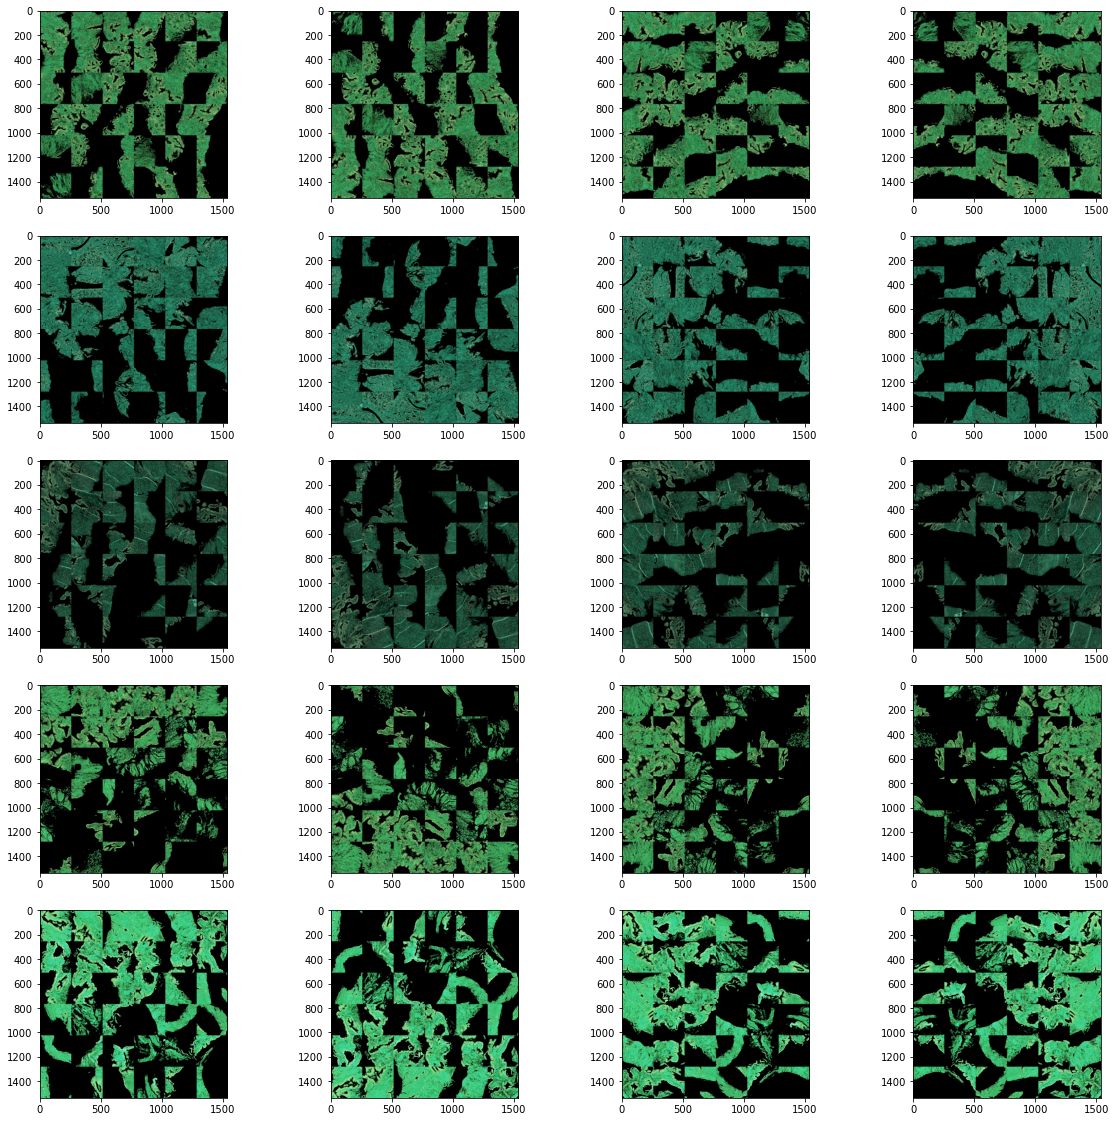

In [14]:
# test dataset
if not is_test:
    ds = MyTestDataset(df)    
    
    # show samples
    fig, ax = plt.subplots(5, 4, figsize=(20, 20))
    for i in range(5):
        for j in range(4):
            x = ds[i]
            ax[i, j].imshow(x[j].permute(1, 2, 0)*0.5+0.5)
            
    del ds, fig, ax

# Model

In [15]:
sys.path.append('../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master/')

In [16]:
from efficientnet_pytorch import EfficientNet

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.base = EfficientNet.from_name('efficientnet-b1')
        self.fc = nn.Linear(self.base._fc.in_features, 1)
        self.base._fc = nn.Identity()
    
    def forward(self, x):
        x = self.base(x)
        x = self.fc(x)
        return x

In [17]:
if not is_test:
    model = MyModel()
    x = torch.randn(1, 3, 1536, 1536) # for b4, it can only accepts 512
    y = model(x)
    print(y.shape)
    
    del model, x, y
    torch.cuda.empty_cache()
    gc.collect()

torch.Size([1, 1])


In [18]:
torch.cuda.empty_cache()
gc.collect()

20

In [19]:
model = MyModel()
model = model.to(device)

ck = torch.load('../input/pandaefnb01/efnb1-best-0.8716.pth', map_location=device)
model.load_state_dict(ck['state_dict'])
_ = model.eval()

# Train

In [20]:
def coef_round(pred):
    coef = ck['coef']
#     coef = [0.48260549, 1.46657575, 2.42520403, 3.73863956, 4.65729487] 

    
    for i in range(len(pred)):
        if pred[i] < coef[0]:
            pred[i] = 0
        elif pred[i] >= coef[0] and pred[i] < coef[1]:
            pred[i] = 1
        elif pred[i] >= coef[1] and pred[i] < coef[2]:
            pred[i] = 2
        elif pred[i] >= coef[2] and pred[i] < coef[3]:
            pred[i] = 3
        elif pred[i] >= coef[3] and pred[i] < coef[4]:
            pred[i] = 4
        elif pred[i] >= coef[4]:
            pred[i] = 5
        
    return pred

In [21]:
# for later cohen
# have to put aside in case the df value got changed
if not is_test:
    y_trues = df.isup_grade.values

In [22]:
# why submission.csv not found
# put placeholder
# if following error happens, the score would be 0
if is_test:
    df['isup_grade'] = np.random.choice(6, len(df))
    df['isup_grade'] = df['isup_grade'].astype(np.int)
    df[['image_id', 'isup_grade']].to_csv('submission.csv', index=False)
    !ls
    display(pd.read_csv('submission.csv').head())

In [23]:
# mode = 0
test_ds = MyTestDataset(df) 
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False) # for 4 tile mean

preds = []
with torch.no_grad():
    for idx, x in tqdm(enumerate(test_dl), total=len(test_dl)):
        x = x.squeeze().to(device, dtype=torch.float32) # (4, 3, 1536, 1536)

        y_preds = []
        for i in range(4):
            p = model(x[i].expand((1, 3, config.IMG_SIZE, config.IMG_SIZE)))
            y_preds.append(p.detach().cpu().numpy())
        y_preds = np.mean(y_preds) # (4, 1) # get mean
        preds.append(y_preds) # add batch preds
    preds = np.array(preds)
        

preds = coef_round(preds)
df['isup_grade'] = preds
df['isup_grade'] = df['isup_grade'].astype(int)
    
    
# see cohen
if not is_test:
    score = cohen_kappa_score(y_trues, preds, weights='quadratic')
    print(score)


0.8235294117647058


In [24]:
df[['image_id', 'isup_grade']].to_csv('submission.csv', index=False)
!ls
pd.read_csv('submission.csv').head()

__notebook__.ipynb  submission.csv


,image_id,isup_grade
0,dbf5972f6e8559cf175c232310070b6e,1
1,3a08f79c589a9e1d00a258e86a1331ce,3
2,a4514f8a6800bf122ae746c4f573ee6f,1
3,11685dcddfbc26b1c8dded45957469dd,0
4,1c3c1fe065c9325cbfcab6722d6b9b39,0
